# XGboost Model (Unique Model)
***


In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
# Suppress warnings
warnings.filterwarnings('ignore')

### Data Loading and processing and Encoding 

In [2]:
# Load dataset
file_path = 'C:/Users/tanej/OneDrive/Documents/preprocessed_thyroid_data.csv'
data = pd.read_csv(file_path)


In [3]:
# Separate features and target
X = data.drop(columns=['target'])
y = data['target']-1

# Display unique target values (possible outcomes)
possible_outcomes = y.unique()
print(f"Possible Outcomes: {possible_outcomes}")



Possible Outcomes: [0 1 2]


### Data Splitting 
#### In training, testing and Validation (70%,15%,15%)

In [4]:
# Split data into training, testing, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [5]:
#  XGBoost model
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss', random_state=42, objective='multi:softprob')


### Hyperparameter tuning

In [6]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)



Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='multi:softprob', ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 1]},
             scoring='accuracy', verbose=1)

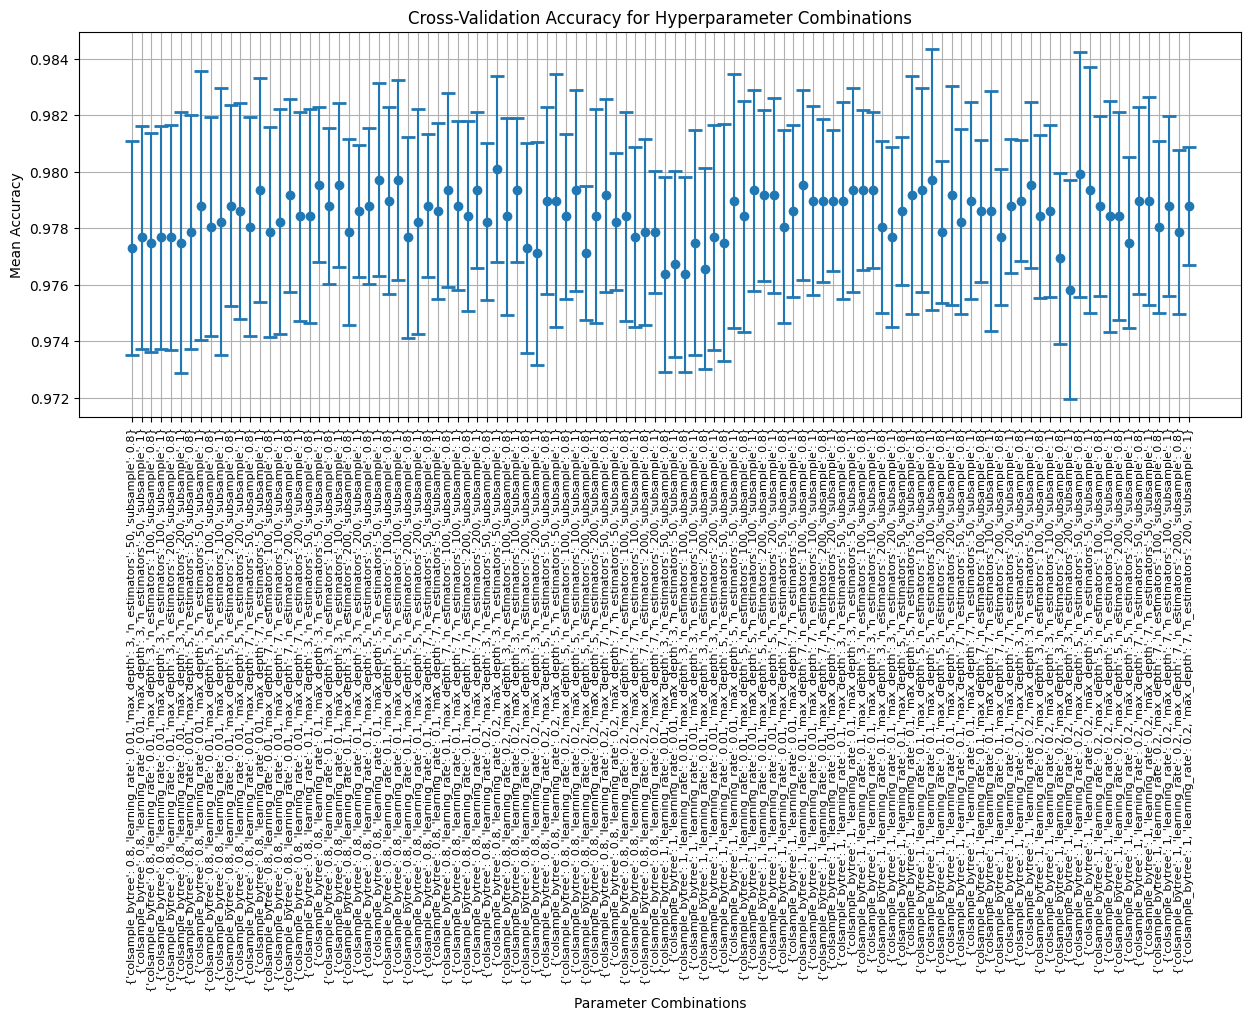

In [7]:
# Plot cross-validation accuracy results
cv_results = grid_search.cv_results_
mean_scores = cv_results['mean_test_score']
std_scores = cv_results['std_test_score']
param_combinations = [str(params) for params in cv_results['params']]

plt.figure(figsize=(15, 5))
plt.errorbar(param_combinations, mean_scores, yerr=std_scores, fmt='o', capsize=5, capthick=2)
plt.xticks(rotation=90, fontsize=8)
plt.title("Cross-Validation Accuracy for Hyperparameter Combinations")
plt.xlabel("Parameter Combinations")
plt.ylabel("Mean Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# Best parameters
print(f"Best Hyperparameters: {grid_search.best_params_}")


Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


### Evaluation on Validation Dataset

Validation Accuracy: 0.9809193408499567
Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1037
           1       0.89      0.74      0.81        42
           2       0.93      0.95      0.94        74

    accuracy                           0.98      1153
   macro avg       0.94      0.89      0.91      1153
weighted avg       0.98      0.98      0.98      1153

Confusion Matrix (Validation):
[[1030    4    3]
 [   9   31    2]
 [   4    0   70]]


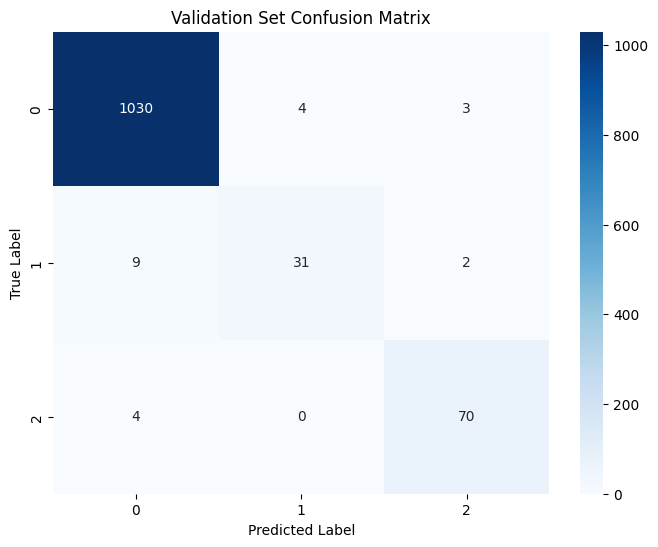

In [9]:
# Evaluate on validation set
best_model = grid_search.best_estimator_
y_pred_val = best_model.predict(X_val)

val_accuracy = accuracy_score(y_val, y_pred_val)
print(f"Validation Accuracy: {val_accuracy}")

# Classification report for validation data
print("Validation Set Classification Report:")
print(classification_report(y_val, y_pred_val))

# Confusion matrix for validation set
conf_matrix_val = confusion_matrix(y_val, y_pred_val)
print("Confusion Matrix (Validation):")
print(conf_matrix_val)

# Plot confusion matrix for validation set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt="d", cmap="Blues", xticklabels=possible_outcomes, yticklabels=possible_outcomes)
plt.title("Validation Set Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### Evaluation on Test Dataset

Test Accuracy: 0.9722222222222222
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1013
           1       0.91      0.69      0.78        58
           2       0.88      0.96      0.92        81

    accuracy                           0.97      1152
   macro avg       0.92      0.88      0.90      1152
weighted avg       0.97      0.97      0.97      1152

Confusion Matrix (Test):
[[1002    4    7]
 [  14   40    4]
 [   3    0   78]]


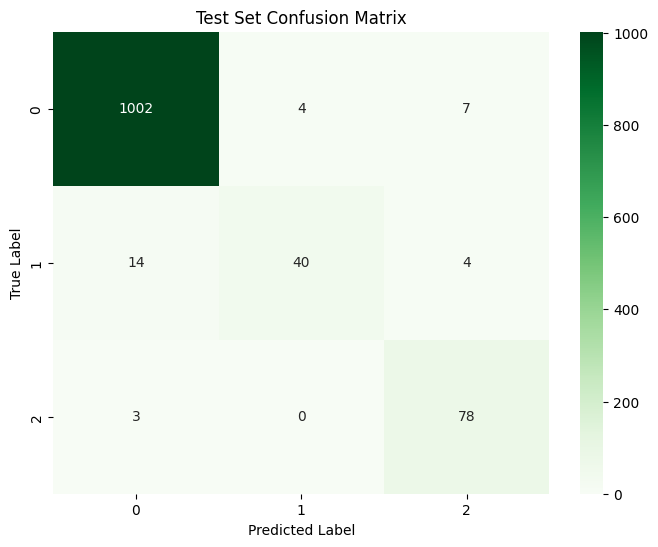

In [10]:
# Evaluate on test set
y_pred_test = best_model.predict(X_test)
y_pred_proba_test = best_model.predict_proba(X_test)  # Use full probability array for multiclass

test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy}")

# Classification report for test data
print("Test Set Classification Report:")
print(classification_report(y_test, y_pred_test))

# Confusion matrix for test set
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix (Test):")
print(conf_matrix_test)


# Plot confusion matrix for test set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Greens", xticklabels=possible_outcomes, yticklabels=possible_outcomes)
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### AUC-ROC Curve

Test Set ROC-AUC Score: 0.9708963716191973


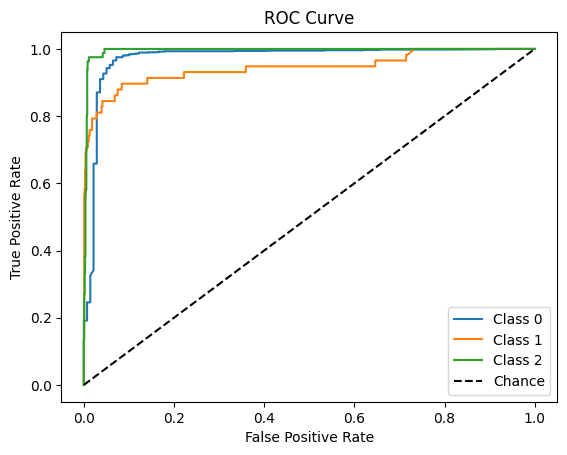

In [11]:
# AUC-ROC Curve for multiclass
roc_auc = roc_auc_score(y_test, y_pred_proba_test, multi_class='ovr')
print(f"Test Set ROC-AUC Score: {roc_auc}")

# Plot ROC Curve for each class
plt.figure()
for i, class_label in enumerate(possible_outcomes):
    fpr, tpr, _ = roc_curve((y_test == class_label).astype(int), y_pred_proba_test[:, i])
    plt.plot(fpr, tpr, label=f"Class {class_label}")

plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


# Logistic Regression Model (Common Model for Group)
***

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


### Data Loading and processing and Encoding 

In [13]:
# Step 1: Load dataset
file_path = 'C:/Users/tanej/OneDrive/Documents/preprocessed_thyroid_data.csv'
preprocessed_data = pd.read_csv(file_path)


In [14]:
# Step 2: Define features and target
X = preprocessed_data.drop(columns=['target'])  # Features
y = preprocessed_data['target']  # Target variable


### Data Splitting 
#### In training, testing and Validation (70%,15%,15%)

In [15]:
# Step 3: Split into 70% training + 30% temporary (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Step 4: Split the temporary set into 15% validation and 15% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

# Step 5: Print the shapes of the splits
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Training set shape: (5376, 10) (5376,)
Validation set shape: (1152, 10) (1152,)
Test set shape: (1153, 10) (1153,)


### Modeling 

In [16]:
# Step 6: Train the Logistic Regression model
model = LogisticRegression(multi_class='ovr', max_iter=500, random_state=42)
model.fit(X_train, y_train)

# Step 7: Predict on the validation set
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)


### Evaluation on Validation Dataset

Validation Accuracy: 0.9435763888888888
Validation Classification Report:
              precision    recall  f1-score   support

           1       0.94      1.00      0.97      1015
           2       0.89      0.36      0.52        47
           3       0.94      0.66      0.77        90

    accuracy                           0.94      1152
   macro avg       0.93      0.67      0.75      1152
weighted avg       0.94      0.94      0.94      1152

Validation Confusion Matrix:
[[1011    2    2]
 [  28   17    2]
 [  31    0   59]]


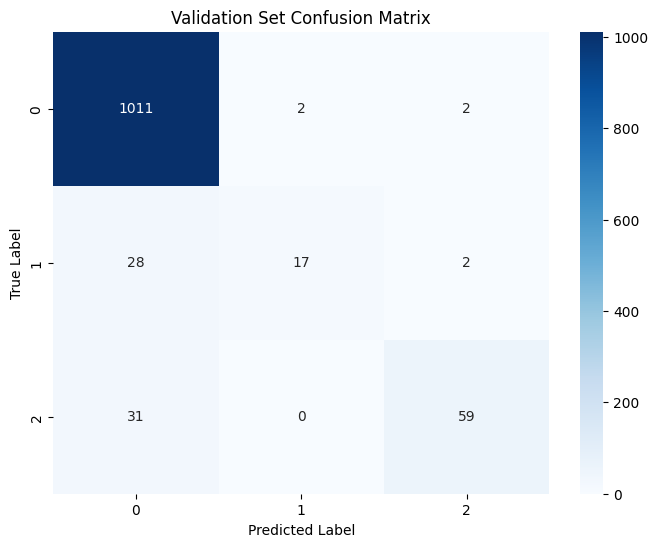

In [17]:
# Step 8: Print classification report and confusion matrix for validation and test

val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy}")
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

# Plot confusion matrix for validation set
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt="d", cmap="Blues", xticklabels=possible_outcomes, yticklabels=possible_outcomes)
plt.title("Validation Set Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



### Evaluation on Test Dataset

Test Accuracy: 0.9332176929748482
Test Classification Report:
              precision    recall  f1-score   support

           1       0.94      0.99      0.96      1016
           2       0.75      0.38      0.51        47
           3       0.89      0.57      0.69        90

    accuracy                           0.93      1153
   macro avg       0.86      0.65      0.72      1153
weighted avg       0.93      0.93      0.92      1153

Test Confusion Matrix:
[[1007    6    3]
 [  26   18    3]
 [  39    0   51]]


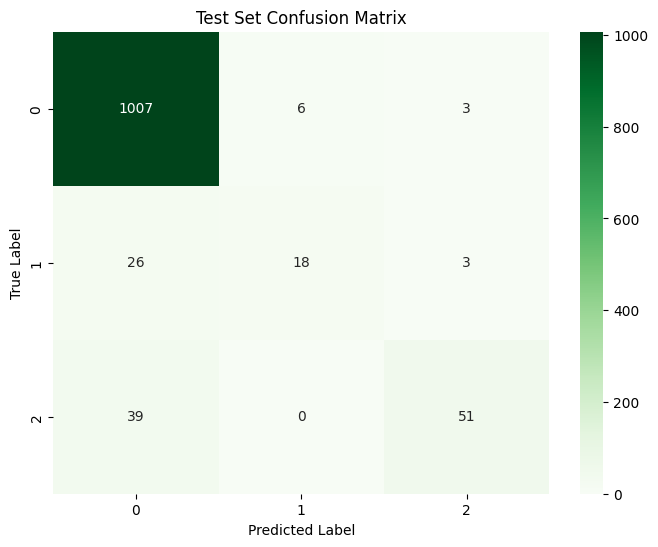

In [18]:

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Plot confusion matrix for test set
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt="d", cmap="Greens", xticklabels=possible_outcomes, yticklabels=possible_outcomes)
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### AUC-ROC Curve

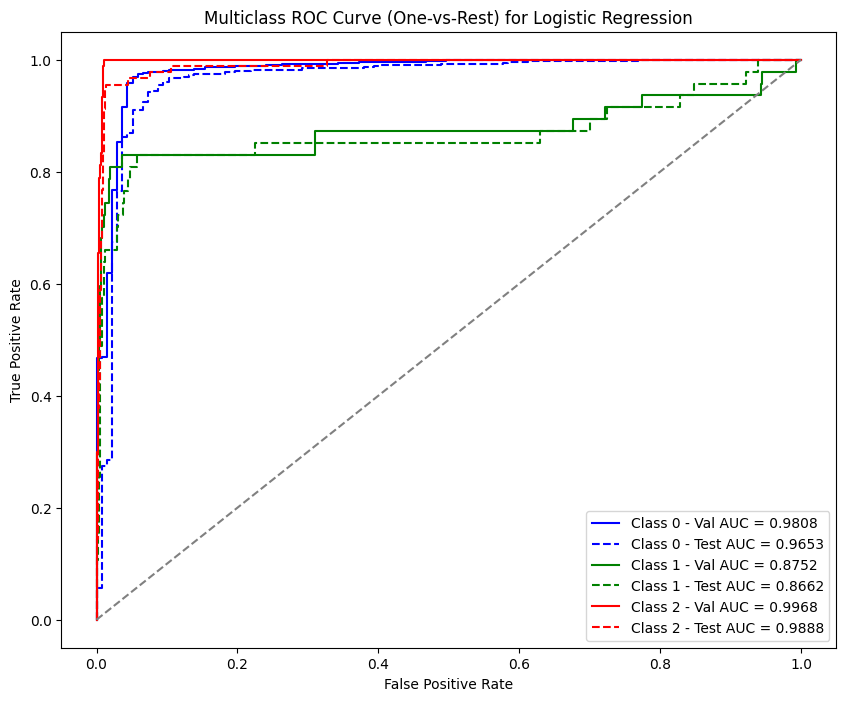

In [19]:
# Step 9: Plot the ROC curve for multiclass classification (One-vs-Rest)
# Binarize the target labels for ROC curve calculation
y_val_bin = label_binarize(y_val, classes=y.unique())  # Adjust classes based on your dataset
y_test_bin = label_binarize(y_test, classes=y.unique())

# Get the predicted probabilities for each class
y_val_pred_prob = model.predict_proba(X_val)
y_test_pred_prob = model.predict_proba(X_test)

# Initialize plot
plt.figure(figsize=(10, 8))

# Calculate and plot ROC curve for each class
n_classes = y_val_bin.shape[1]
colors = ['b', 'g', 'r']  # Use colors for different classes

for i in range(n_classes):
    # ROC curve for the current class
    fpr_val, tpr_val, _ = roc_curve(y_val_bin[:, i], y_val_pred_prob[:, i])
    fpr_test, tpr_test, _ = roc_curve(y_test_bin[:, i], y_test_pred_prob[:, i])

    # AUC for the current class
    roc_auc_val = auc(fpr_val, tpr_val)
    roc_auc_test = auc(fpr_test, tpr_test)

    # Plot ROC curve for the validation set
    plt.plot(fpr_val, tpr_val, color=colors[i], label=f'Class {i} - Val AUC = {roc_auc_val:.4f}')
    # Plot ROC curve for the test set
    plt.plot(fpr_test, tpr_test, color=colors[i], linestyle='--', label=f'Class {i} - Test AUC = {roc_auc_test:.4f}')

# Plot the diagonal line (no skill classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (One-vs-Rest) for Logistic Regression')
plt.legend(loc='lower right')

# Show the plot
plt.show()

### Comparison Between XGBoost and Logistic Regression
1. Accuracy:

    * XGBoost achieved a higher accuracy (97.22%) compared to Logistic Regression (93.23%), demonstrating its ability to handle complex patterns in the data effectively.

2. Class-wise Performance:

    * For Class 1 (majority class), both models performed well, achieving high precision and recall.
    * For Class 2 (minority class), XGBoost outperformed Logistic Regression, achieving better recall and reducing false negatives, making it more suitable for critical medical applications. Logistic Regression struggled with a recall of only 38% for this class.

3. Handling Data Complexity:

    * XGBoost excels at modeling non-linear relationships and capturing interactions between features, making it ideal for datasets with class imbalances.
    * Logistic Regression relies on linear decision boundaries, which limits its ability to accurately classify minority classes and handle complex datasets.

4. Suitability for Medical Applications:

    * XGBoost is better suited for medical datasets, where minimizing false negatives for minority classes is crucial to ensure accurate diagnoses and timely treatment.
    * Logistic Regression is easier to interpret and serves as a strong baseline but lacks the robustness required for handling imbalanced data effectively.

*** 

In summary, while Logistic Regression offers simplicity and interpretability, XGBoost provides superior performance and is the preferred choice for medical datasets requiring high accuracy and balanced class predictions.